In [2]:
import torch
import torchvision
from torchvision.datasets import MNIST

In [3]:
dataset = MNIST(root='data/',download=True)

100.0%


Extracting data/MNIST\raw\train-images-idx3-ubyte.gz to data/MNIST\raw



102.8%


Extracting data/MNIST\raw\train-labels-idx1-ubyte.gz to data/MNIST\raw



100.0%


Extracting data/MNIST\raw\t10k-images-idx3-ubyte.gz to data/MNIST\raw



112.7%


Extracting data/MNIST\raw\t10k-labels-idx1-ubyte.gz to data/MNIST\raw



In [4]:
len(dataset)

60000

In [5]:
test_dataset = MNIST(root='data/', train=False)
len(test_dataset)

10000

In [6]:
train_dataset = MNIST(root= 'data/',train = True)
len(train_dataset)

60000

In [7]:
dataset[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x2416ED86D00>, 5)

In [16]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, '5')

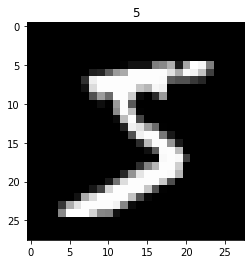

In [17]:
img, label = dataset[0]
plt.imshow(img,cmap='gray')
plt.title(str(label))

Text(0.5, 1.0, '2')

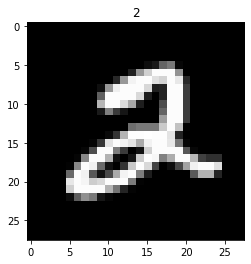

In [18]:
img, label = dataset[5]
plt.imshow(img,cmap='gray')
plt.title(str(label))

In [20]:
type(img)

PIL.Image.Image

Convert Images into tensor

In [22]:
from torchvision.transforms import transforms

In [23]:
dataset = MNIST(root = 'data/',download=True,transform=transforms.ToTensor())

In [25]:
img, _ = dataset[0]
print(type(img),img.shape)

<class 'torch.Tensor'> torch.Size([1, 28, 28])


In [27]:
from torch.utils.data import random_split

In [28]:
datasize = len(dataset)
train_split = 0.75
test_split = 0.25

train_size = int(datasize*train_split)
test_size = datasize - train_size

In [29]:
train_ds, test_ds = random_split(dataset,[train_size,test_size])
print(len(train_ds),len(test_ds))

45000 15000


In [30]:
from torch.utils.data import DataLoader
batch_size = 256

train_loader = DataLoader(train_ds,batch_size = batch_size,shuffle=True)
test_loader = DataLoader(test_ds,batch_size = batch_size,shuffle=True)

Model

In [43]:
import torch.nn as nn
import torch.nn.functional as F
input_size = 28*28
num_class = 10
model = nn.Linear(input_size, num_class)

In [38]:
print(model.weight.shape)
model.weight

torch.Size([10, 784])


Parameter containing:
tensor([[-0.0138,  0.0343, -0.0229,  ..., -0.0284,  0.0133, -0.0288],
        [-0.0311,  0.0288,  0.0138,  ..., -0.0013,  0.0118, -0.0310],
        [-0.0006, -0.0193, -0.0043,  ..., -0.0091, -0.0340, -0.0059],
        ...,
        [ 0.0241, -0.0240,  0.0330,  ..., -0.0046, -0.0197, -0.0342],
        [-0.0096,  0.0202, -0.0321,  ...,  0.0191,  0.0266,  0.0352],
        [-0.0077,  0.0005, -0.0117,  ...,  0.0234,  0.0277, -0.0107]],
       requires_grad=True)

In [39]:
print(model.bias.shape)
model.bias

torch.Size([10])


Parameter containing:
tensor([ 0.0210, -0.0044,  0.0335, -0.0023,  0.0145,  0.0136,  0.0165, -0.0116,
        -0.0180,  0.0065], requires_grad=True)

In [45]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [52]:
class MNIST_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size,num_class)
    
    def forward(self,xb):
        xb = xb.reshape(-1,input_size)
        out = self.linear(xb)
        return out
    
    def training_step(self,data):
        img, label = data
        out = self(img)
        loss = F.cross_entropy(out,label)
        return loss
    
    def validation_step(self,data):
        img, label = data
        out = self(img)
        loss = F.cross_entropy(out,label)
        acc = accuracy(out,label)
        return {'val_loss':loss,'val_acc':acc}

    def validation_epoch_end(self,output):
        batch_loss = [x['val_loss'] for x in output]
        epoch_loss = torch.stack(batch_loss).mean()
        batch_acc = [x['val_acc'] for x in output]
        epoch_acc = torch.stack(batch_acc).mean()
        return {'val_loss':epoch_loss.item(),'val_acc':epoch_acc.item()}
    
    def epoch_end(self,epoch,result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [47]:
model = MNIST_Model()

In [42]:
for img,labels in train_loader:
    print(img.shape)
    pred = model(img)
    break
print(pred.shape,pred)

torch.Size([256, 1, 28, 28])
torch.Size([256, 10]) tensor([[ 0.1469,  0.1402,  0.0594,  ..., -0.4235, -0.0064, -0.0928],
        [ 0.0279,  0.2279, -0.1736,  ..., -0.3422, -0.1239, -0.1529],
        [ 0.3514, -0.1006, -0.1226,  ..., -0.0508, -0.0117, -0.0647],
        ...,
        [-0.0772, -0.0443, -0.0749,  ..., -0.2945, -0.1790, -0.0932],
        [-0.2306,  0.1007,  0.1942,  ..., -0.2144,  0.1073,  0.0647],
        [-0.0586,  0.3418, -0.2084,  ...,  0.0082, -0.3420, -0.0161]],
       grad_fn=<AddmmBackward0>)


In [48]:
def eval(model,data):
    output = [model.validation_step(batch) for batch in data]
    return model.validation_epoch_end(output)

In [49]:
def fit(Epochs,lr,model,train_loader,val_loader,opt_func = torch.optim.SGD):
    optimizer = opt_func(model.parameters(),lr)
    history = []

    for epochs in range(Epochs):
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        result = eval(model,val_loader)
        model.epoch_end(epochs,result)
        history.append(result)
    
    return history

In [53]:
history = fit(50,0.001,model,train_loader,test_loader)

torch.Size([256, 784])
torch.Size([256, 784])
torch.Size([256, 784])
torch.Size([256, 784])
torch.Size([256, 784])
torch.Size([256, 784])
torch.Size([256, 784])
torch.Size([256, 784])
torch.Size([256, 784])
torch.Size([256, 784])
torch.Size([256, 784])
torch.Size([256, 784])
torch.Size([256, 784])
torch.Size([256, 784])
torch.Size([256, 784])
torch.Size([256, 784])
torch.Size([256, 784])
torch.Size([256, 784])
torch.Size([256, 784])
torch.Size([256, 784])
torch.Size([256, 784])
torch.Size([256, 784])
torch.Size([256, 784])
torch.Size([256, 784])
torch.Size([256, 784])
torch.Size([256, 784])
torch.Size([256, 784])
torch.Size([256, 784])
torch.Size([256, 784])
torch.Size([256, 784])
torch.Size([256, 784])
torch.Size([256, 784])
torch.Size([256, 784])
torch.Size([256, 784])
torch.Size([256, 784])
torch.Size([256, 784])
torch.Size([256, 784])
torch.Size([256, 784])
torch.Size([256, 784])
torch.Size([256, 784])
torch.Size([256, 784])
torch.Size([256, 784])
torch.Size([256, 784])
torch.Size(

Text(0.5, 1.0, 'Accuracy vs. No. of epochs')

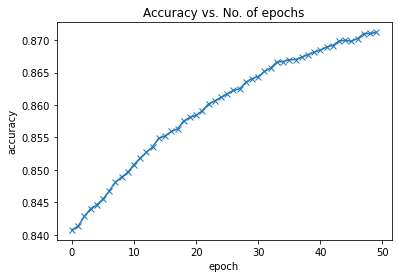

In [54]:
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs')